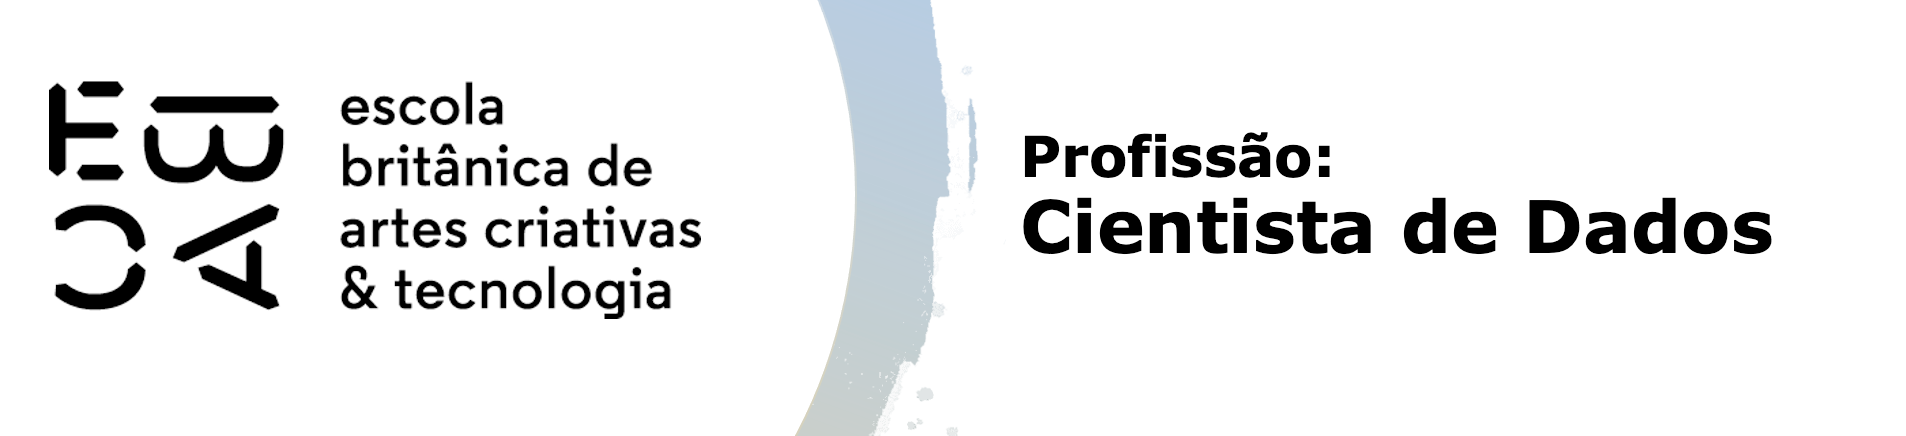

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [69]:
# Importando os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
import warnings ; warnings.filterwarnings('ignore')
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score


%matplotlib inline

In [70]:
# Carregando os dados
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## 1. Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [71]:
# Ordenando o dataframe pela data
df.sort_values('data_ref', inplace=True)

# Encontrando a data que marca o início dos últimos três meses
start_oot = df['data_ref'].unique()[-3]

# Criando o conjunto de validação out of time
df_oot = df[df['data_ref'] >= start_oot]

# Criando o conjunto de treinamento
df_train = df[df['data_ref'] < start_oot]


## 2. Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [72]:
# Número de linhas
num_linhas = df.shape[0]
print(f'Número de linhas: {num_linhas}')

# Número de linhas para cada mês em 'data_ref'
num_linhas_data_ref = df['data_ref'].value_counts()
print('Número de linhas para cada mês em data_ref:')
print(num_linhas_data_ref)

Número de linhas: 750000
Número de linhas para cada mês em data_ref:
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64


In [73]:
# Descritiva básica univariada de cada variável
for col in df.columns:
    print(f'\nDescritiva básica univariada para {col}:')
    if df[col].dtype == 'object':
        # Se a variável é qualitativa, mostra a frequência de cada categoria
        print(df[col].value_counts())
    else:
        # Se a variável é quantitativa, mostra medidas resumo como média, mediana, etc.
        print(df[col].describe())


Descritiva básica univariada para data_ref:
count                  750000
unique                     15
top       2015-01-01 00:00:00
freq                    50000
first     2015-01-01 00:00:00
last      2016-03-01 00:00:00
Name: data_ref, dtype: object

Descritiva básica univariada para index:
count    750000.000000
mean       8319.272793
std        4809.281774
min           0.000000
25%        4147.000000
50%        8324.000000
75%       12487.000000
max       16649.000000
Name: index, dtype: float64

Descritiva básica univariada para sexo:
F    504580
M    245420
Name: sexo, dtype: int64

Descritiva básica univariada para posse_de_veiculo:
N    457954
S    292046
Name: posse_de_veiculo, dtype: int64

Descritiva básica univariada para posse_de_imovel:
S    503692
N    246308
Name: posse_de_imovel, dtype: int64

Descritiva básica univariada para qtd_filhos:
count    750000.000000
mean          0.433251
std           0.739379
min           0.000000
25%           0.000000
50%          

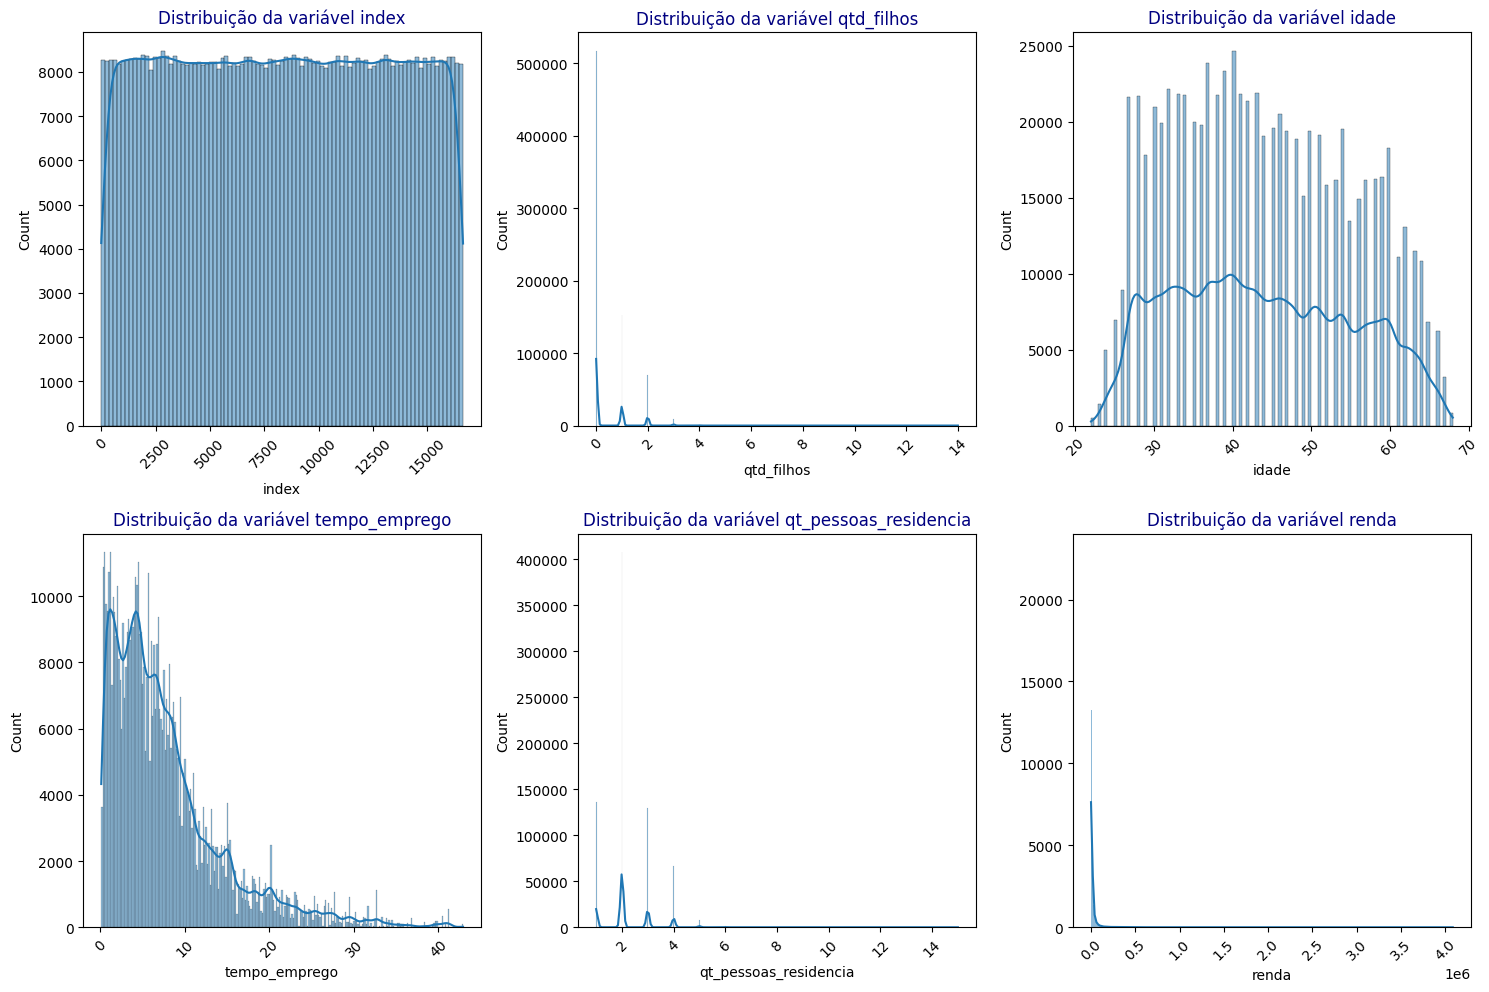

In [74]:
# Gráficos para variáveis quantitativas
quant_vars = df.select_dtypes(include=[np.number]).columns
n_rows = int(np.ceil(len(quant_vars)/3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axs = axs.flatten()  # para facilitar a iteração
for i, col in enumerate(quant_vars):
    sns.histplot(data=df, x=col, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribuição da variável {col}', color='navy')
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

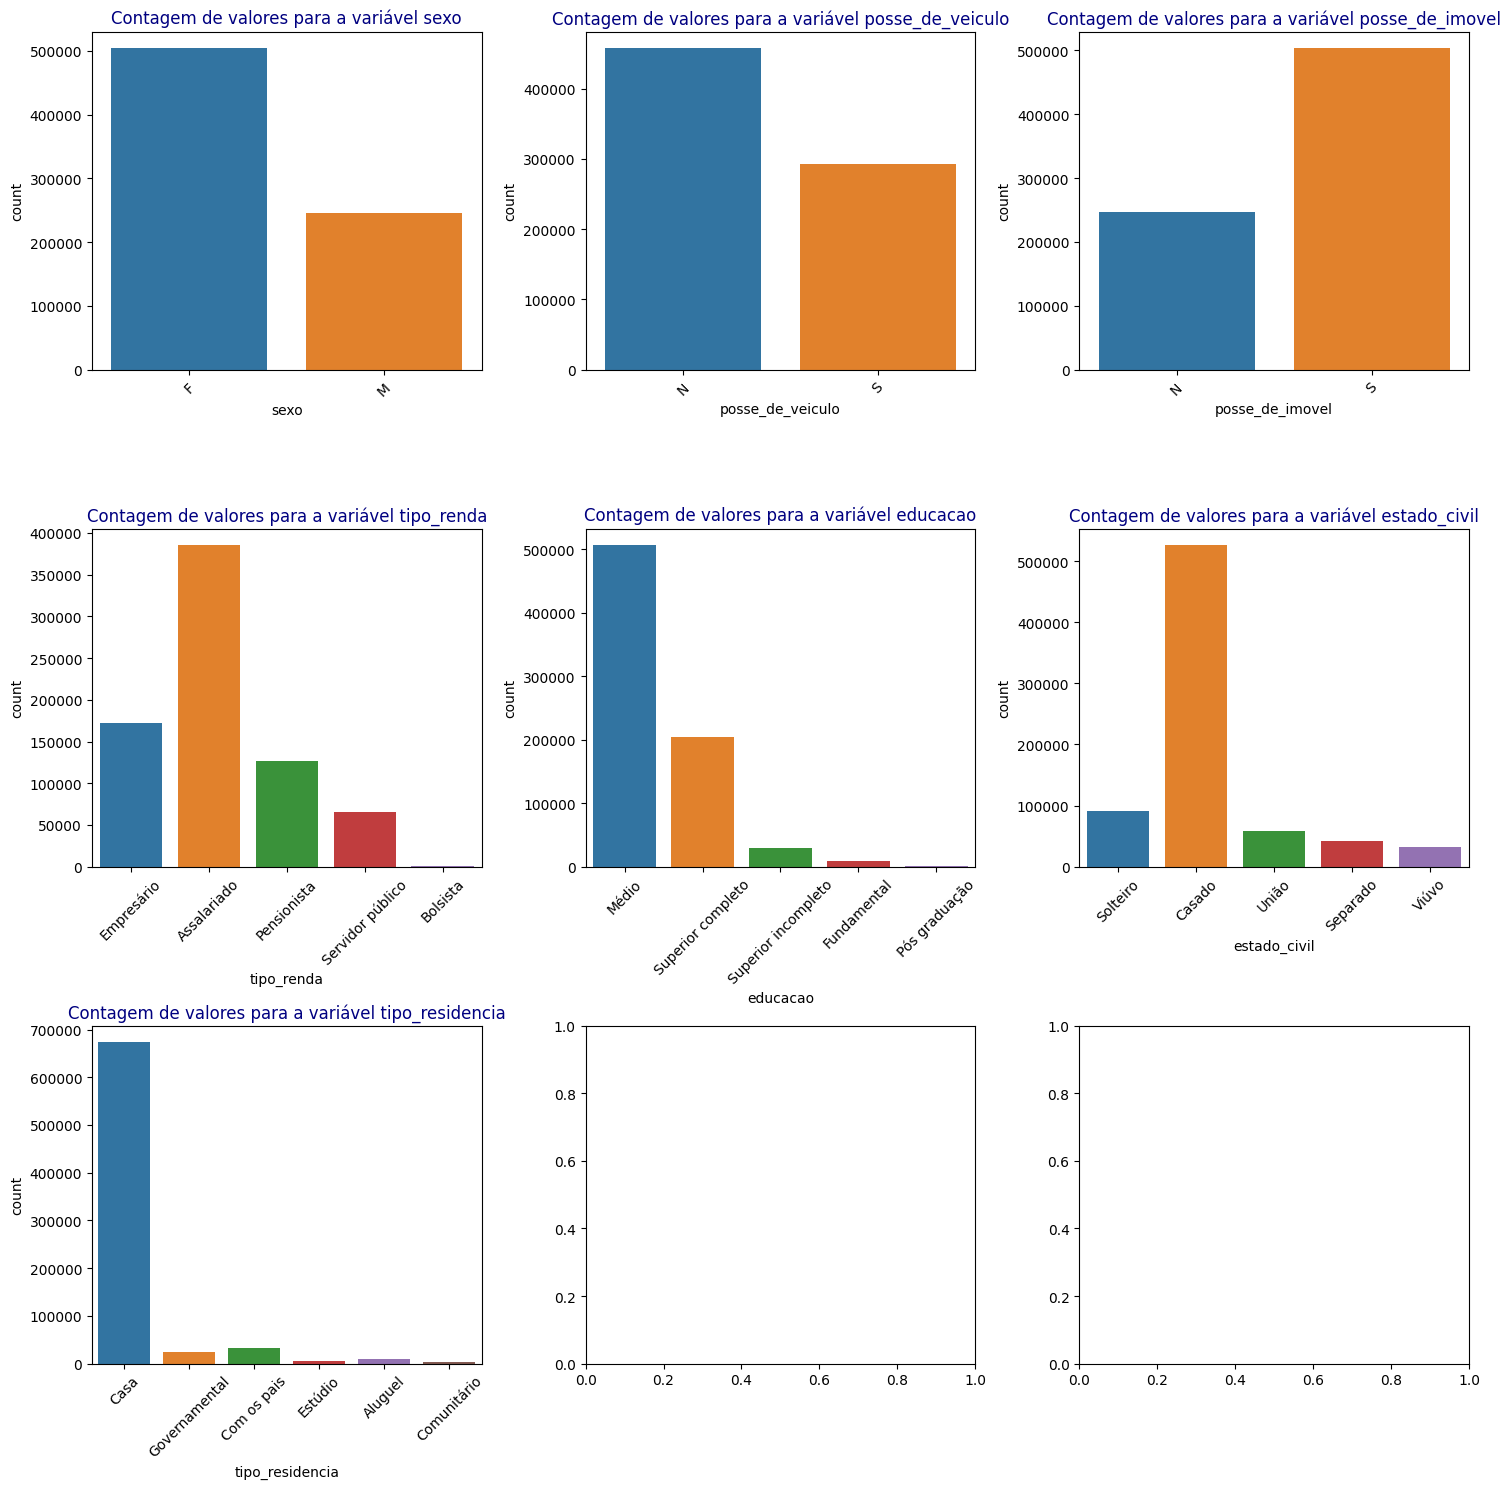

In [75]:
# Gráficos para variáveis qualitativas
qual_vars = df.select_dtypes(include=['object']).columns
n_rows = int(np.ceil(len(qual_vars)/3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axs = axs.flatten()  # para facilitar a iteração
for i, col in enumerate(qual_vars):
    sns.countplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(f'Contagem de valores para a variável {col}', color='navy')
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

## 3. Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [76]:
# Para variáveis qualitativas, podemos usar uma tabela de contingência
qual_vars = df.select_dtypes(include=['object']).columns
for i in range(len(qual_vars)):
    for j in range(i+1, len(qual_vars)):
        contingency_table = pd.crosstab(df[qual_vars[i]], df[qual_vars[j]])
        print(f'Tabela de contingência entre {qual_vars[i]} e {qual_vars[j]}:')
        print(contingency_table)

Tabela de contingência entre sexo e posse_de_veiculo:
posse_de_veiculo       N       S
sexo                            
F                 371028  133552
M                  86926  158494
Tabela de contingência entre sexo e posse_de_imovel:
posse_de_imovel       N       S
sexo                           
F                156662  347918
M                 89646  155774
Tabela de contingência entre sexo e tipo_renda:
tipo_renda  Assalariado  Bolsista  Empresário  Pensionista  Servidor público
sexo                                                                        
F                235395       361      113774       108016             47034
M                150345         0       58938        18249             17888
Tabela de contingência entre sexo e educacao:
educacao  Fundamental   Médio  Pós graduação  Superior completo  \
sexo                                                              
F                5403  342166            591             137952   
M                3172  164670 

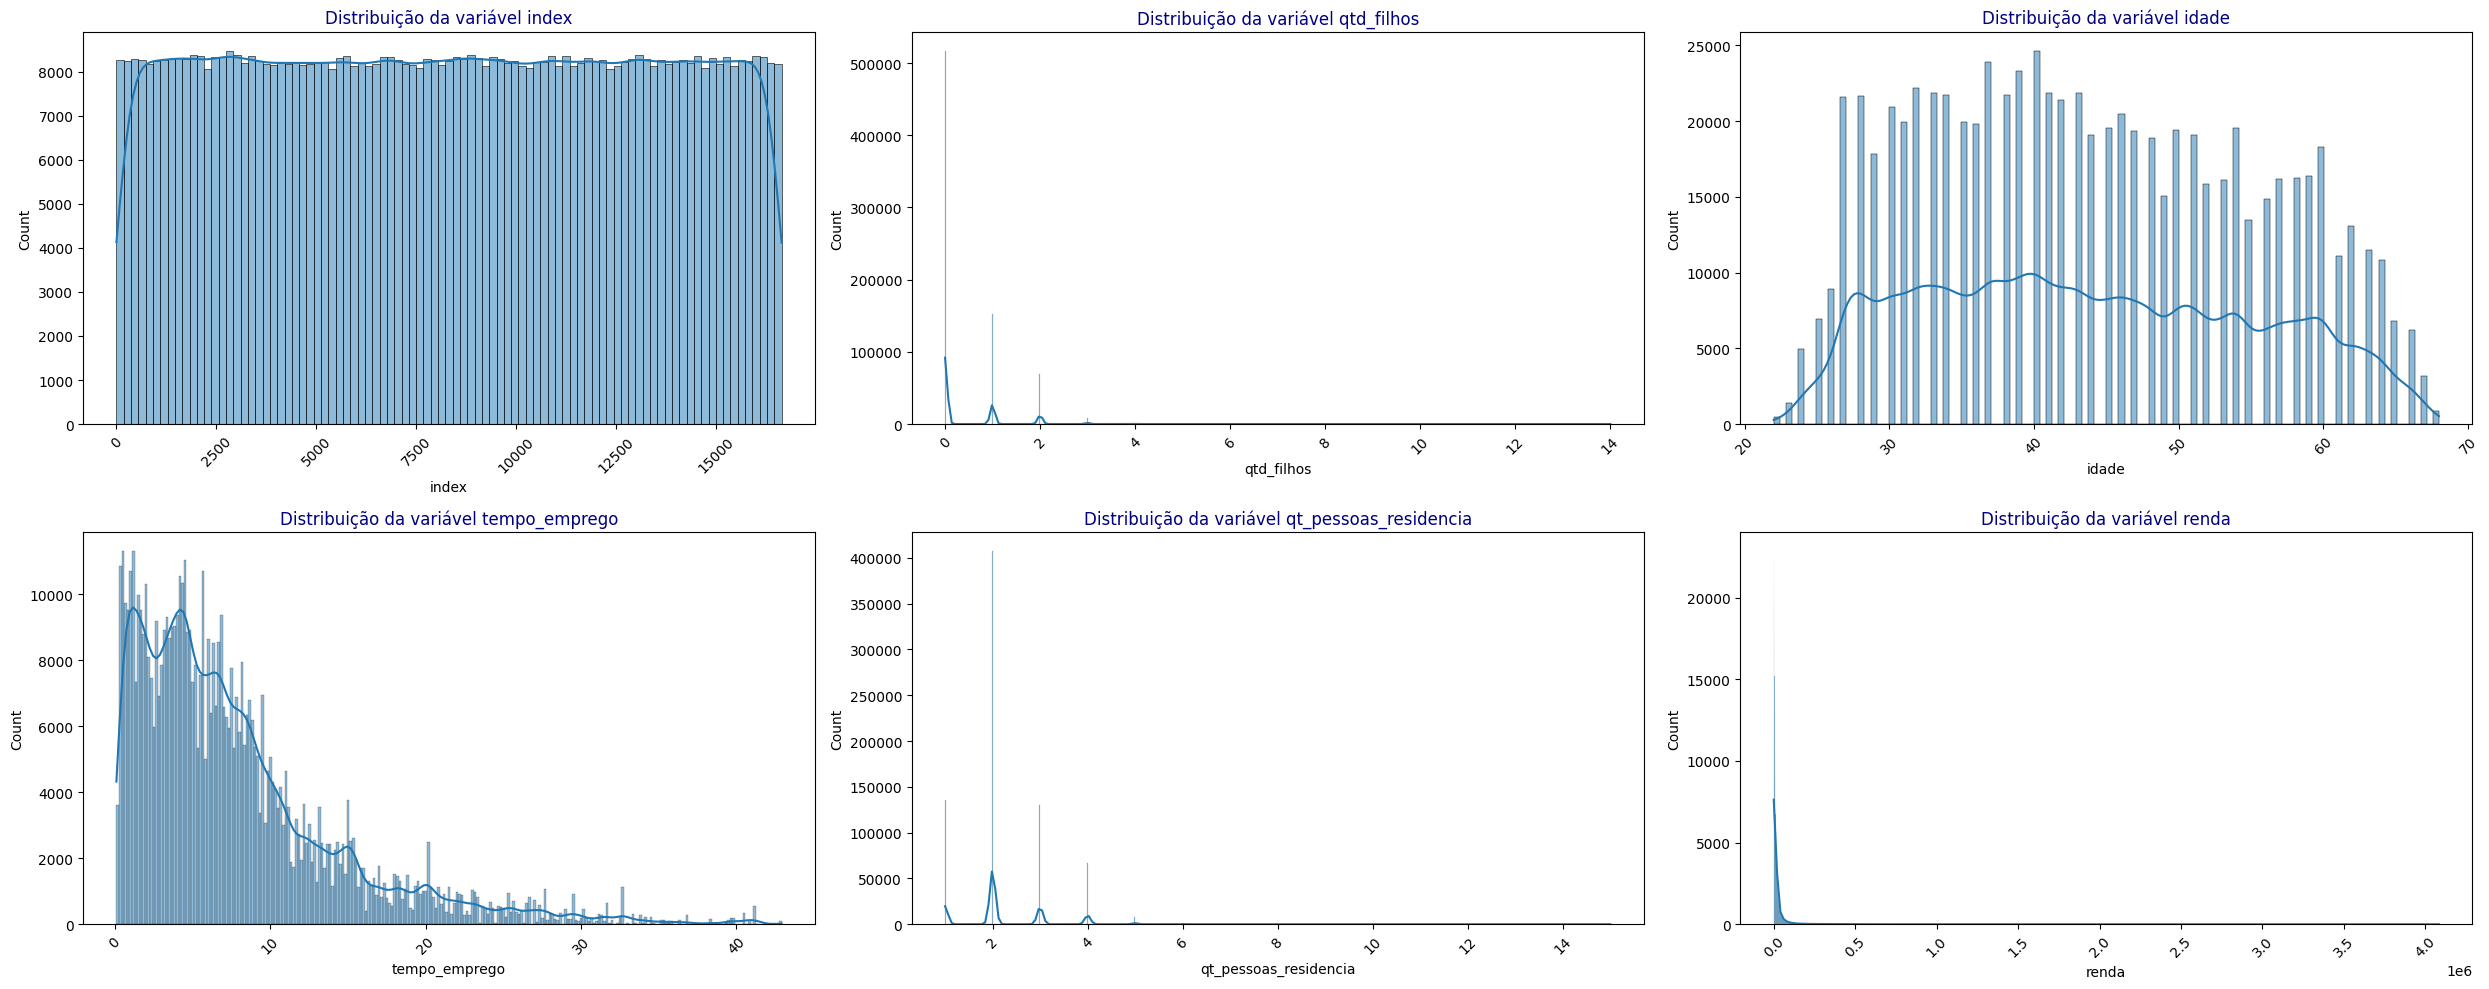

In [77]:
# Gráficos para variáveis quantitativas
quant_vars = df.select_dtypes(include=[np.number]).columns
n_rows = int(np.ceil(len(quant_vars)/3))
fig, axs = plt.subplots(n_rows, 3, figsize=(25, 5*n_rows))
axs = axs.flatten()  # para facilitar a iteração
for i, col in enumerate(quant_vars):
    sns.histplot(data=df, x=col, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribuição da variável {col}', color='navy')
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()



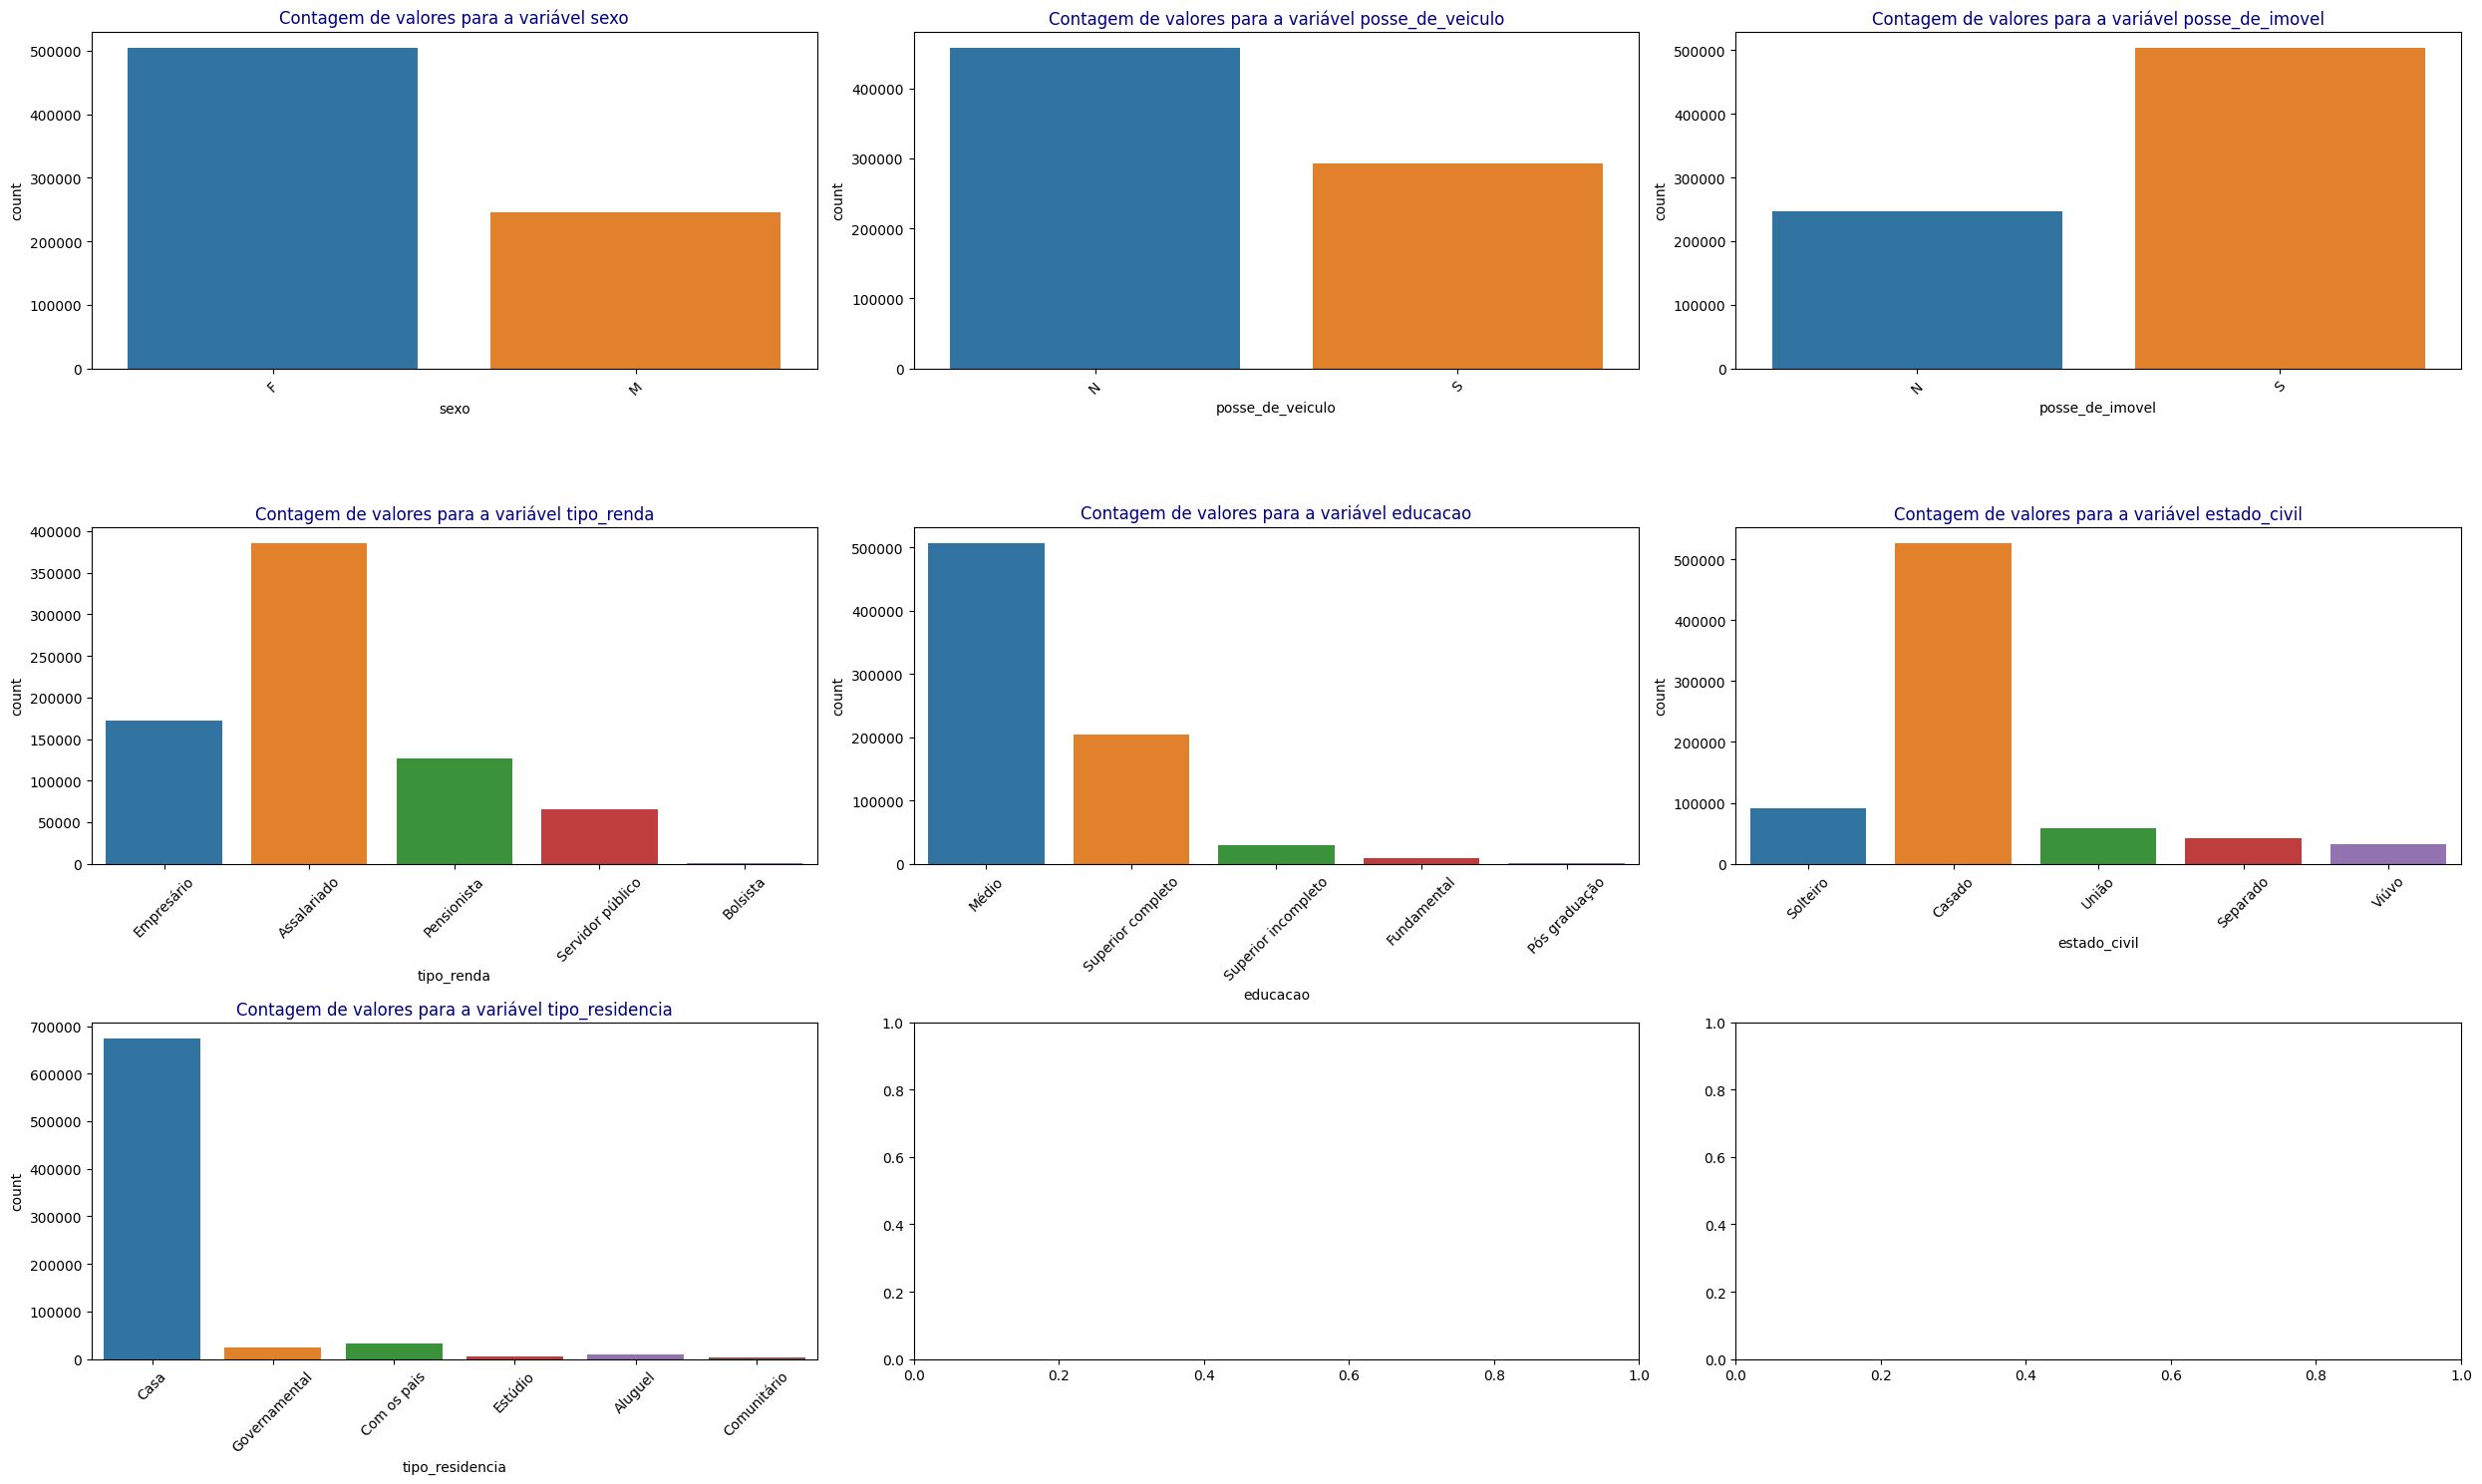

In [78]:
# Gráficos para variáveis qualitativas
qual_vars = df.select_dtypes(include=['object']).columns
n_rows = int(np.ceil(len(qual_vars)/3))
fig, axs = plt.subplots(n_rows, 3, figsize=(25, 5*n_rows))
axs = axs.flatten()  # para facilitar a iteração
for i, col in enumerate(qual_vars):
    sns.countplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(f'Contagem de valores para a variável {col}', color='navy')  # altere 'navy' para a cor desejada
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()


Com base na análise bivariada, podemos observar algumas relações interessantes entre as variáveis. Aqui estão algumas observações resumidas:

1. **Sexo e posse de veículo/imóvel**: A maioria das mulheres não possui veículo, enquanto a maioria dos homens possui. No entanto, tanto homens quanto mulheres são mais propensos a possuir imóveis do que a não possuir.

2. **Sexo e tipo de renda**: A maioria das mulheres são assalariadas, enquanto uma proporção significativa também é empresária ou pensionista. A maioria dos homens são assalariados, mas uma proporção significativa também é empresária.

3. **Posse de veículo e tipo de residência**: A maioria das pessoas que não possuem veículo moram em casa própria, enquanto uma proporção significativa mora com os pais ou em residências governamentais. Aqueles que possuem veículos também são mais propensos a morar em casa própria.

4. **Posse de imóvel e tipo de renda**: Aqueles que não possuem imóveis são mais propensos a serem assalariados ou empresários. Aqueles que possuem imóveis também são mais propensos a serem assalariados ou empresários.

5. **Posse de imóvel e educação**: Aqueles que não possuem imóveis são mais propensos a ter educação média ou superior completa. Aqueles que possuem imóveis também são mais propensos a ter educação média ou superior completa.

6. **Posse de imóvel e estado civil**: Aqueles que não possuem imóveis são mais propensos a serem casados. Aqueles que possuem imóveis também são mais propensos a serem casados.

7. **Tipo de renda e educação**: A maioria dos assalariados, empresários e servidores públicos têm educação média. No entanto, uma proporção significativa também tem ensino superior completo.

8. **Tipo de renda e estado civil**: A maioria dos assalariados, empresários e pensionistas são casados.

9. **Tipo de renda e tipo de residência**: A maioria dos assalariados, empresários e servidores públicos moram em casa própria. No entanto, uma proporção significativa de assalariados e empresários também mora com os pais ou em residências governamentais.

10. **Educação e estado civil**: A maioria das pessoas com educação fundamental, média, pós-graduação, superior completo e superior incompleto são casadas.

11. **Educação e tipo de residência**: A maioria das pessoas com educação fundamental, média, pós-graduação, superior completo e superior incompleto moram em casa própria.


## 4. Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [79]:
# Tratamento de valores missing
# Preenchendo os valores missing com a mediana (para variáveis numéricas) ou a moda (para variáveis categóricas)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)


In [80]:
print(df.isnull().sum())


data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64


In [81]:
# Tratamento de outliers
# Substitua os outliers pelo valor do percentil 95 (para valores altos) ou percentil 5 (para valores baixos)
for col in df.select_dtypes(include=[np.number]).columns:
    P95 = df[col].quantile(0.95)
    P5 = df[col].quantile(0.05)
    df[col] = np.where(df[col] > P95, P95, df[col])
    df[col] = np.where(df[col] < P5, P5, df[col])

# Tratamento de 'zeros estruturais'
# Substituindo os 'zeros estruturais' pela mediana
for col in df.select_dtypes(include=[np.number]).columns:
    median = df.loc[df[col] != 0, col].median()
    df[col] = np.where(df[col] == 0, median, df[col])

# Tratamento de variáveis de data/hora
# Substituindo a variável de data/hora por várias variáveis numéricas
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col+'_ano'] = df[col].dt.year
    df[col+'_mes'] = df[col].dt.month
    df[col+'_dia'] = df[col].dt.day
    df[col+'_dia_da_semana'] = df[col].dt.weekday
    df = df.drop(col, axis=1)


In [82]:
# Agrupamento de categorias
# Agrupando as categorias com frequências muito baixas em uma única categoria 'Outros'
for col in df.select_dtypes(include=['object']).columns:
    freq = df[col].value_counts(normalize=True)
    small_categories = freq[freq < 0.01].index
    df[col] = np.where(df[col].isin(small_categories), 'Outros', df[col])

# Codificação das variáveis categóricas
df = pd.get_dummies(df, drop_first=True)


In [83]:
# Separação das variáveis independentes e dependente
X = df.drop('mau', axis=1)
y = df['mau']


In [87]:
# Divisão dos dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [88]:
# Padronização das variáveis independentes
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [89]:
# Ajuste do modelo de regressão logística
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [90]:
# Avaliação do modelo
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))


[[138364      0]
 [ 11636      0]]


In [91]:
# Avaliação do modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96    138364
        True       0.00      0.00      0.00     11636

    accuracy                           0.92    150000
   macro avg       0.46      0.50      0.48    150000
weighted avg       0.85      0.92      0.89    150000



Os resultados mostram que o modelo tem uma precisão geral de 92%, o que significa que ele classifica corretamente 92% dos casos. No entanto, ao olhar para as métricas de precisão, recall e f1-score para a classe True (clientes que são 'maus'), vemos que todas são 0. Isso indica que o modelo não está conseguindo identificar corretamente os clientes 'maus'.

A matriz de confusão também mostra isso. Dos 11636 clientes 'maus' reais no conjunto de teste, o modelo não identificou corretamente nenhum deles. Isso é um problema, pois na prática, queremos que nosso modelo seja capaz de identificar os clientes 'maus' para que possamos tomar medidas apropriadas.

Isso pode ser devido a várias razões, como um desequilíbrio de classes no conjunto de dados (muito mais clientes 'bons' do que 'maus'), ou pode ser que as variáveis que temos no conjunto de dados não sejam suficientes ou relevantes para prever corretamente a variável de destino.


## 5. Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [92]:
# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy}')

# Calculando o KS
ks_statistic, ks_pvalue = ks_2samp(y_pred[y_test == 0], y_pred[y_test == 1])
print(f'KS: {ks_statistic}')

# Calculando o Gini
roc_auc = roc_auc_score(y_test, y_pred)
gini = 2*roc_auc - 1
print(f'Gini: {gini}')


Acurácia: 0.9224266666666666
KS: 0.0
Gini: 0.0


Os resultados mostram que o modelo tem uma acurácia de 92,24%, o que significa que ele classifica corretamente 92,24% dos casos. No entanto, o valor KS e Gini são ambos 0, o que indica que o modelo não está conseguindo distinguir entre as classes.

O valor KS é uma medida da distância entre as distribuições cumulativas de eventos e não eventos. Um valor KS de 0 sugere que as distribuições de eventos e não eventos são idênticas.

O coeficiente de Gini é uma medida de desigualdade ou pureza de uma divisão. Um valor Gini de 0 sugere que todas as divisões são igualmente puras, ou seja, o modelo não está conseguindo distinguir entre as classes.